# Notebook 2 — EDA & Hypothesis Testing

This notebook performs exploratory data analysis (EDA) and hypothesis testing to examine
how listing characteristics (e.g., superhost status, listing type, ratings) relate to
annual Airbnb revenue (LTM, USD).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## Load Prepared Data

Load the cleaned and prepared dataset produced in Notebook 1.


In [ ]:
data_path = "/content/airbnb_prepared.csv"
df = pd.read_csv(data_path)

print("Loaded:", df.shape)
df.head()


Loaded: (145825, 36)


,listing_title,property_type,listing_type,amenities,country,state,city,city_file_clean,bedrooms,bathrooms,max_guests,minimum_stay,number_of_reviews,overall_rating,airbnb_value_rating,airbnb_location_rating,airbnb_cleanliness_rating,airbnb_accuracy_rating,airbnb_communication_rating,cleaning_fee_usd,extra_people_fee_usd,average_daily_rate_usd,occupancy_rate_ltm,annual_revenue_ltm_usd,count_available_days_ltm,count_blocked_days_ltm,count_reservation_days_ltm,number_of_bookings_ltm,airbnb_superhost,instant_bookable,pets_allowed,latitude,longitude,created_date,last_scraped_date,amenities_count
0,Waterfront Cozy Escape,Private room in rental unit,private_room,"['Free parking on premises', 'Wifi', 'TV', 'Ha...",CA,Ontario,Toronto,Toronto,2.0,1,4,3,79,4.8,10.0,10.0,10.0,10.0,10.0,80.0,7.98889,100,87,21568,224,141,162,26,True,0.0,False,43.587961,-79.53622,2023-07-31,2024-01-10,29
1,Live by the Lake Ontario-Entire Apartment,Entire condo,entire_home,"['Free parking on premises', 'Wifi', 'Kitchen'...",CA,Ontario,Toronto,Toronto,2.0,1,4,28,19,4.8,10.0,10.0,10.0,10.0,10.0,45.0,0.00000,102,71,2407,32,333,19,2,False,0.0,False,43.589160,-79.53253,2023-07-31,2024-01-10,31
2,Home away from home.,Private room in rental unit,private_room,"['Free parking on premises', 'Elevator', 'Wifi...",CA,Ontario,Toronto,Toronto,1.0,1,2,28,5,5.0,9.0,10.0,10.0,10.0,10.0,7.0,0.00000,74,51,6550,173,192,73,3,False,1.0,False,43.588320,-79.53094,2023-07-31,2024-01-10,56
3,"❤️Beautiful HOUSE!, near everything! LAKE+WIFI...",Entire home,entire_home,"['Free parking on premises', 'Wifi', 'Kitchen'...",CA,Ontario,Toronto,Toronto,1.0,1,2,28,50,4.9,10.0,10.0,10.0,10.0,10.0,118.0,0.00000,65,51,3176,78,287,33,5,True,0.0,False,43.590000,-79.52848,2023-07-31,2024-01-10,46
4,💕BEAUTIFUL BSMT STUDIO By LAKE! + wifi PRKN & ...,Entire home,entire_home,"['Free parking on premises', 'Breakfast', 'Wif...",CA,Ontario,Toronto,Toronto,1.0,1,2,28,46,5.0,10.0,10.0,10.0,10.0,10.0,118.0,15.73330,84,68,17958,271,94,153,21,True,0.0,False,43.591560,-79.52895,2023-07-31,2024-01-10,51


## Basic Type Fixes

Parse date columns and ensure boolean columns are consistently typed.


In [ ]:
# dates
for c in ["created_date", "last_scraped_date"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# bool columns may come as strings
bool_cols = ["airbnb_superhost", "instant_bookable", "pets_allowed"]
for c in bool_cols:
    if c in df.columns:
        df[c] = df[c].replace({"t": True, "f": False, "True": True, "False": False})
        df[c] = df[c].astype("boolean")

df[bool_cols].head()


,airbnb_superhost,instant_bookable,pets_allowed
0,True,False,False
1,False,False,False
2,False,True,False
3,True,False,False
4,True,False,False


## Missingness & Quick Summary

Inspect missing values and basic descriptive statistics.


In [ ]:
print(df.isna().mean().sort_values(ascending=False).head(15))
df.describe(include="all").T.head(20)


instant_bookable               0.435549
airbnb_cleanliness_rating      0.148438
overall_rating                 0.142986
airbnb_value_rating            0.133681
airbnb_location_rating         0.133667
airbnb_accuracy_rating         0.133660
airbnb_communication_rating    0.133653
state                          0.104248
bedrooms                       0.074973
cleaning_fee_usd               0.039390
extra_people_fee_usd           0.039390
listing_title                  0.000041
amenities                      0.000000
listing_type                   0.000000
property_type                  0.000000
dtype: float64


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
listing_title,145819,141286,Sextant Habitat 10mins to Beach Gym Pool Balcony,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_type,145825,148,Entire rental unit,56847,NaN,NaN,NaN,NaN,NaN,NaN,NaN
listing_type,145825,4,entire_home,104109,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amenities,145825,131794,[],101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,145825,6,US,67186,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,130623,14,UK,43580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,145825,2429,Greater London,34527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_file_clean,145825,9,London,43580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bedrooms,134892.0,NaN,NaN,NaN,1.632447,0.0,1.0,1.0,2.0,36.0,1.040501
bathrooms,145825.0,NaN,NaN,NaN,1.458481,0.0,1.0,1.0,2.0,42.0,0.858042


## Target Cleaning (Annual Revenue)

We keep only listings with a valid, positive annual revenue value.
We also print checks to verify how many rows are removed by the filters.


In [ ]:
target = "annual_revenue_ltm_usd"

# checks BEFORE filtering
print("Before filtering shape:", df.shape)
print("Missing target:", df[target].isna().sum())
print("Target <= 0:", (df[target] <= 0).sum())

# sanity filters
df = df[df[target].notna()].copy()
df = df[df[target] > 0].copy()

print("After filtering shape:", df.shape)
df[target].describe()


Before filtering shape: (145825, 36)
Missing target: 0
Target <= 0: 0
After filtering shape: (145825, 36)


,annual_revenue_ltm_usd
count,1.458250e+05
mean,1.795272e+04
std,2.588228e+04
min,2.000000e+00
25%,2.916000e+03
50%,9.150000e+03
75%,2.323400e+04
max,1.290235e+06


## Revenue Distribution (EDA)

Revenue is typically heavy-tailed (a small number of listings earn extremely high revenue).
A log-scale histogram helps visualize the distribution.


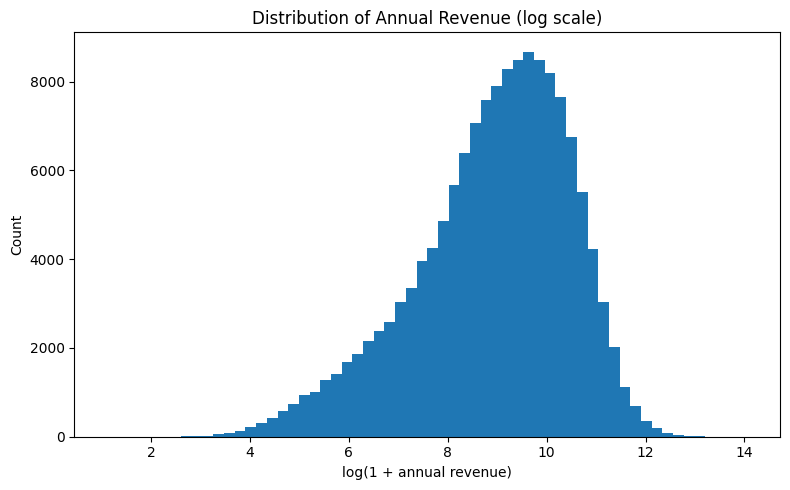

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(np.log1p(df[target]), bins=60)
plt.xlabel("log(1 + annual revenue)")
plt.ylabel("Count")
plt.title("Distribution of Annual Revenue (log scale)")
plt.tight_layout()
plt.show()


## City-Level Comparison (EDA)

Compare city-level annual revenue using median (robust to outliers).


In [ ]:
city_summary = (df.groupby("city_file_clean")[target]
                  .agg(["count","median","mean"])
                  .sort_values("median", ascending=False))

city_summary


,count,median,mean
city_file_clean,,,
Sydney,5938,17271.5,23830.310879
Tokyo,9661,16680.0,23798.211779
SanFransisco,3801,11627.0,23971.320442
Miami,10205,10702.0,19935.314062
NYC,40343,9293.0,17870.830875
London,43580,9029.5,16948.696053
LA,12837,6394.0,19220.850432
Dubai,13560,6256.5,12932.155310
Toronto,5900,5976.5,11914.657288


## Top Cities by Median Revenue (Plot)


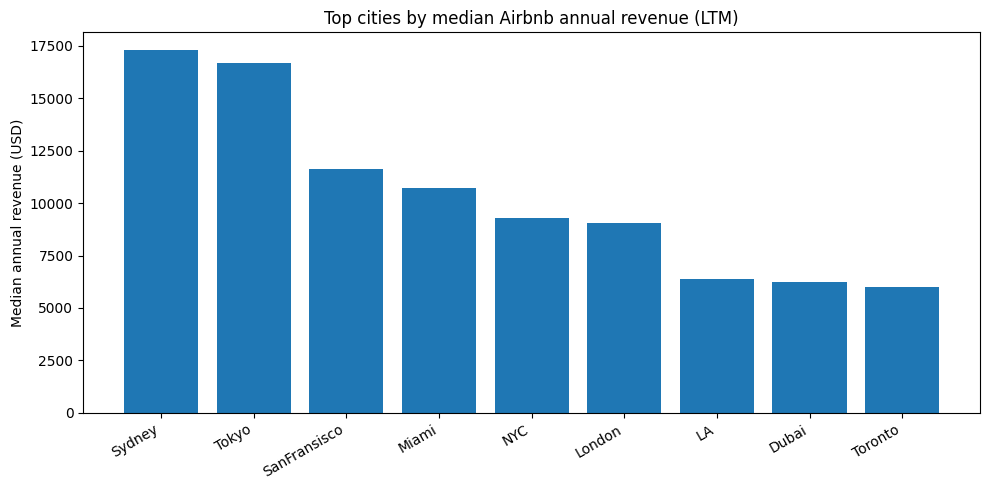

In [ ]:
top10 = city_summary.head(10).reset_index()

plt.figure(figsize=(10,5))
plt.bar(top10["city_file_clean"], top10["median"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("Median annual revenue (USD)")
plt.title("Top cities by median Airbnb annual revenue (LTM)")
plt.tight_layout()
plt.show()


## Hypothesis Testing Setup

Because revenue is not normally distributed (heavy-tailed), we use **non-parametric tests**:

- **Mann–Whitney U** for group comparisons (H1, H2)
- **Spearman correlation** for rating vs revenue (H3)

Significance level: α = 0.05


## H1 — Superhost Effect

H0: No difference in annual revenue between superhosts and non-superhosts.  
H1: Superhosts have higher annual revenue than non-superhosts.


In [ ]:
a = df[df["airbnb_superhost"] == True][target]
b = df[df["airbnb_superhost"] == False][target]

u_stat_two, p_two = stats.mannwhitneyu(a, b, alternative="two-sided")
u_stat_greater, p_one = stats.mannwhitneyu(a, b, alternative="greater")

print("n_superhost:", len(a), " n_non:", len(b))
print("Median superhost:", np.median(a), "Median non:", np.median(b))
print(f"Mann-Whitney U (two-sided) p = {p_two:.3e}")
print(f"Mann-Whitney U (superhost > non) p = {p_one:.3e}")


n_superhost: 46026  n_non: 99799
Median superhost: 15380.5 Median non: 7069.0
Mann-Whitney U (two-sided) p = 0.000e+00
Mann-Whitney U (superhost > non) p = 0.000e+00


## H2 — Listing Type Effect

H0: No difference in annual revenue between entire_home and private_room listings.  
H1: entire_home listings have higher annual revenue than private_room listings.


In [ ]:
x = df[df["listing_type"] == "entire_home"][target]
y = df[df["listing_type"] == "private_room"][target]

u_stat, p_one = stats.mannwhitneyu(x, y, alternative="greater")

print("n_entire:", len(x), " n_private:", len(y))
print("Median entire:", np.median(x), "Median private:", np.median(y))
print(f"Mann-Whitney U (entire_home > private_room) p = {p_one:.3e}")


n_entire: 104109  n_private: 39279
Median entire: 11748.0 Median private: 4903.0
Mann-Whitney U (entire_home > private_room) p = 0.000e+00


## H3 — Rating vs Revenue Relationship

H0: No monotonic relationship between overall rating and annual revenue.  
H1: There is a monotonic relationship between rating and revenue (Spearman).

Note: With large sample sizes, very small effects can still be statistically significant.
So we report both **rho (effect size)** and **p-value**.


In [ ]:
tmp = df[[target, "overall_rating"]].dropna()
rho, p = stats.spearmanr(tmp["overall_rating"], tmp[target])

print("n =", len(tmp))
print("Spearman rho =", rho)
print(f"p = {p:.3e}")


n = 124974
Spearman rho = 0.04278936805352351
p = 9.733e-52


## Scatter Plot (Sample)

A scatter plot is shown using a sample for readability.


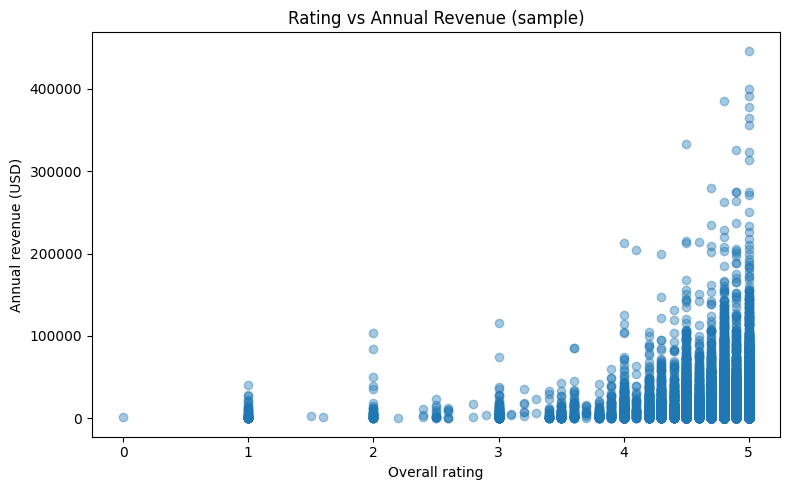

In [ ]:
tmp = df[[target, "overall_rating"]].dropna()
if len(tmp) > 15000:
    tmp = tmp.sample(15000, random_state=42)

plt.figure(figsize=(8,5))
plt.scatter(tmp["overall_rating"], tmp[target], alpha=0.4)
plt.xlabel("Overall rating")
plt.ylabel("Annual revenue (USD)")
plt.title("Rating vs Annual Revenue (sample)")
plt.tight_layout()
plt.show()


## Summary Table of Hypothesis Tests

Collect all hypothesis test p-values and mark whether we reject H0 at α = 0.05.


In [ ]:
results = []

# H1 superhost
a = df[df["airbnb_superhost"] == True][target]
b = df[df["airbnb_superhost"] == False][target]
_, p1 = stats.mannwhitneyu(a, b, alternative="greater")
results.append(("H1: Superhost revenue > Non-superhost", p1))

# H2 entire_home
x = df[df["listing_type"] == "entire_home"][target]
y = df[df["listing_type"] == "private_room"][target]
_, p2 = stats.mannwhitneyu(x, y, alternative="greater")
results.append(("H2: Entire home revenue > Private room", p2))

# H3 rating correlation
tmp = df[[target, "overall_rating"]].dropna()
_, p3 = stats.spearmanr(tmp["overall_rating"], tmp[target])
results.append(("H3: Rating correlated with revenue (Spearman)", p3))

out = pd.DataFrame(results, columns=["Hypothesis", "p_value"])
out["reject_H0_at_0.05"] = out["p_value"] < 0.05

# nicer display
out["p_value"] = out["p_value"].apply(lambda v: f"{v:.3e}")
out


,Hypothesis,p_value,reject_H0_at_0.05
0,H1: Superhost revenue > Non-superhost,0.000e+00,True
1,H2: Entire home revenue > Private room,0.000e+00,True
2,H3: Rating correlated with revenue (Spearman),9.733e-52,True


## Key Findings (from this notebook)

- **H1:** Superhost listings have higher annual revenue than non-superhost listings (reject H0).
- **H2:** Entire-home listings have higher annual revenue than private-room listings (reject H0).
- **H3:** Rating has a statistically significant but **very weak** positive relationship with revenue
  (small rho; significance is amplified by large sample size).

These findings will be used to guide feature selection and model design in the ML notebook.
